# Cvvpp

Very short draft on a way to measure the velocity correlation function.. weighted by orientation and persistence of motion.

It's not yet enough, IMHO, and there may be some bugs here and there

In [1]:
%pylab inline
import numpy as np
import pylab as plt
import pickle as pkl

Populating the interactive namespace from numpy and matplotlib


In [2]:
com = np.load('G_data/gug_com.pkl')

In [3]:
ori = np.load('G_data/gug_ori.pkl') 

In [4]:
(com-ori).sum()

0.0

Something wrong with `ori.pkl`

In [5]:
com.shape

(1250, 2, 10001)

In [6]:
com_frame = com[:,:,0]

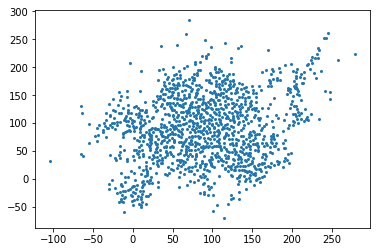

In [7]:
plt.plot(*com_frame.T,'o',ms=2); #?? isn't it PBC?

## Velocity

In [8]:
from scipy.ndimage.filters import gaussian_filter1d as GF

In [9]:
SIGMA = 20

In [10]:
velocity = GF(np.diff(com,axis=-1),sigma=SIGMA,axis=2)
speed = (velocity**2).sum(axis=1)**.5
ori   = velocity/speed[:,np.newaxis] # this should really come from a direct measure

In [11]:
print (velocity.shape)
print(speed.shape)
print(ori.shape)

(1250, 2, 10000)
(1250, 10000)
(1250, 2, 10000)


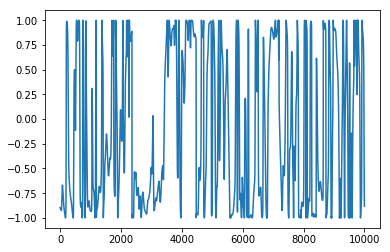

In [12]:
plt.plot(ori[0,0])

## correlation function velocity velocity orientation

We expect the presence of flow and counter flow and just passive rods. So we weight by a measure of persistence of motion $P$, then the correlation of velocities can be either positive or negative, so averaging over the angle (bcs C(r)) will, on average, give negative correlation or 0 bcs only few particles stream togheter hence the p_ip_j.


$$
P_i = p_i(r,t)\cdot p_i(r,t-1)
$$
$$
C(r,t)=\langle v_i(r,t)\cdot v_j(r,t)\; p_i\cdot p_j\; P_iP_j\rangle_{i>j}
$$

In [13]:
from scipy.spatial.distance import cdist,squareform

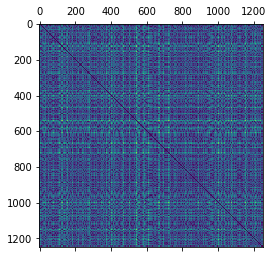

In [14]:
TIME = 100

com_frame = com[:,:,TIME]
P_frame = (ori[:,:,TIME]*ori[:,:,TIME-SIGMA]).sum(axis=1) # quantifies how much correlated we are wrt prev step. Should depend on sigma of GF
vel_frame = velocity[:,:,TIME]

distances = cdist(com_frame,com_frame)

plt.matshow(distances)

In [15]:
one = (vel_frame[:,:,np.newaxis]*vel_frame.T).sum(axis=1)
two = np.einsum('ij,kj->ik',vel_frame,vel_frame)
np.allclose(one,two)

True

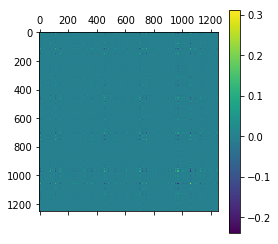

In [16]:
plt.figure(figsize=(10,10))
plt.matshow(one)
plt.colorbar()

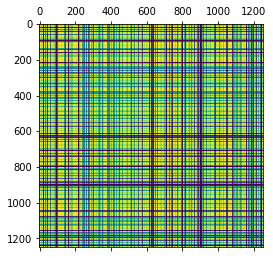

In [17]:
PP = (P_frame[:,np.newaxis]*P_frame.T)**2
plt.matshow(PP)

# All togheter

In [18]:
com_frame = com[:,:,TIME]
OO_frame = ori[:,:,TIME]
P_frame = (ori[:,:,TIME]*ori[:,:,TIME-SIGMA]).sum(axis=1)
vel_frame = velocity[:,:,TIME]

vel_frame -=vel_frame.mean()
OO_frame  -=OO_frame.mean()

distances = cdist(com_frame,com_frame)
Cijr = np.einsum('ij,kj->ik',vel_frame,vel_frame)*np.einsum('ij,kj->ik',OO_frame,OO_frame)*P_frame[:,np.newaxis]*P_frame.T


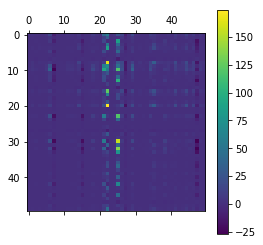

In [19]:
plt.matshow((Cijr/np.diag(Cijr))[:50,:50])
plt.colorbar()

In [26]:
def Cvvpp(TIME):
    bins = np.arange(0,300,5)
    hist = np.zeros(len(bins)+1)

    com_frame = com[:,:,TIME]
    P_frame = (ori[:,:,TIME]*ori[:,:,TIME-SIGMA]).sum(axis=1)
    vel_frame = velocity[:,:,TIME]

    distances = cdist(com_frame,com_frame)
    Cijr = np.einsum('ij,kj->ik',vel_frame,vel_frame)*np.einsum('ij,kj->ik',OO_frame,OO_frame)*P_frame[:,np.newaxis]*P_frame.T
#     Cijr /= np.diag(Cijr)
    
    for i in range(com.shape[0]):
        for j in range(i,com.shape[0]):
            d_ij = distances[i,j]
            bin = np.digitize(d_ij,bins)
            hist[bin]+=Cijr[i,j]
    return hist

In [29]:
%%time 

_ = Cvvpp(1100);

CPU times: user 1.83 s, sys: 19.8 ms, total: 1.85 s
Wall time: 1.84 s


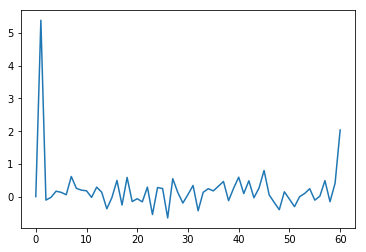

In [30]:
plt.plot(_)

In [23]:
from tqdm import tqdm_notebook as tqdm

In [24]:
def parallel_Cvvpp(TIMES=None):
    if TIMES is None:
        TIMES = range(com.shape[-1])
    try:
        # "async" as long as numpy releases GIL here and there or process pool is used
        from concurrent import futures
        with futures.ProcessPoolExecutor(max_workers=4) as executor:
            corr = executor.map(Cvvpp,TIMES)
            corr = [i for i in  tqdm(corr,total=len(TIMES))]
    except ImportError:
        print ("you don't have futures??? ")
        corr = [Cvvpp(j) for j in tqdm(TIMES)]
    return np.asarray(corr)

In [37]:
hists = parallel_Cvvpp(range(5000,com.shape[-1]-1,SIGMA)) # jump by SIGMA, bcs we averaged over time with GF with width SIGMA

HBox(children=(IntProgress(value=0, max=250), HTML(value='')))

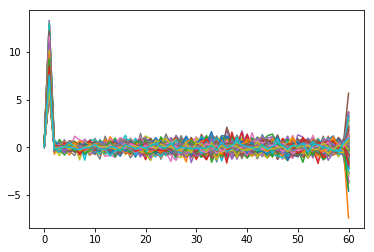

In [41]:
plt.plot(hists.T);

### Just Cvv

in the pipeline